## BREVE INTRODUZIONE ALLA STAZIONARIETÀ DELLE TIME SERIES
da [iaml](https://iaml.it/blog/serie-storiche-4-stazionarieta?fbclid=IwAR2-koZQuv065ejLnQtennHwW6qVU4p6EYrCpY0aGKT8BrbWehno_wwhclQ) - Italian Association for Machine Learning

Continuano i nostri articoli dedicati alle serie storiche! Nei due post precedenti abbiamo parlato di tecniche non supervisionate, [Dynamic Time Warping](https://iaml.it/blog/serie-storiche-3-dynamic-time-warping) e [SAX Encoding](https://iaml.it/blog/serie-storiche-2-sax-encoding). In questo articolo vedremo cos'è la stazionarietà di una serie storica, come fare per capire se una serie è stazionaria o no, e come renderla stazionaria.

In [1]:
import time
import numpy as np
import pandas as pd

import datetime as dt
from datetime import datetime, timedelta, date  
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
from joblib import dump, load

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, RANSACRegressor, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA, KernelPCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn import metrics
#import xgboost as xgb 

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss

#!pip install yfinance
import yfinance as yf


import warnings
warnings.filterwarnings("ignore")

print("done...")

done...


In [2]:
start = dt.datetime(2018,1,2).strftime('%Y-%m-%d')
#end = dt.datetime(2020,1,2).strftime('%Y-%m-%d')
end = datetime.now().strftime('%Y-%m-%d')

signals_df = yf.Ticker('^DJI').history(start=start, end=end, interval="1d").drop(columns=['Volume','Dividends', 'Stock Splits'])

signals_df['target'] = signals_df['Close'].shift(-1)
signals_df.dropna(inplace=True)

signals_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 750 entries, 2018-01-02 to 2020-12-22
Data columns (total 5 columns):
Open      750 non-null float64
High      750 non-null float64
Low       750 non-null float64
Close     750 non-null float64
target    750 non-null float64
dtypes: float64(5)
memory usage: 35.2 KB


Dopo aver caricato Airpassenger, il primo step è controllare se nella serie sono presenti tutte le quattro componenti:

* Trend, T(t)→Rappresenta l’andamento nel lungo periodo della serie. E’ rappresentabile con una funzione matematica semplice, che nel caso della retta e’ identificabile nella regressione lineare di z rispetto a t.
* Componente ciclica, C(t) →Rappresenta l’alternanza di fasi fra due periodi, pertanto facilmente confondibile con il trend. Per questa ragione questa componente viene solitamente associata al trend
* Componente stagionale, S(t) → Rappresenta il ripetersi regolare di effetti, per serie con rilevazioni inferiori all’anno (mese, trimestri,…).
* Componente casuale o erratica, a(t)→Rappresenta la casualità del comportamento della serie privata delle altre componenti.

Per far ciò statsmodel mette a disposizione la funzione [seasonal_decompose](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html).  

N.B.  
La differenza tra ciclo e stagionalità: La stagionalità si presenta sui dodici mesi, il ciclo può essere mensile, settimanale, o ad altre frequenze.  
La componente casuale o erratica rappresenta la casualità del comportamento della serie privata delle altre componenti.

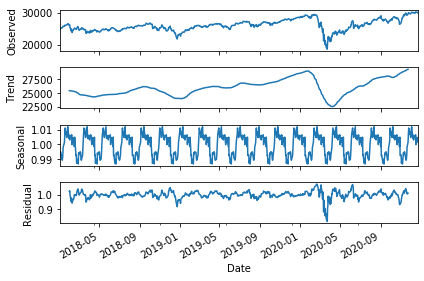

In [3]:
decompose = seasonal_decompose(signals_df["Close"], model = "multiplicative", freq = 40)

decompose.plot()
plt.show()

## TEST SULLA STAZIONARIETÀ

### Analisi visuale delle autocorrelazioni

Data una serie temporale Xt con t∈1,2,...,N, l'analisi delle autocorrelazioni ci dice se e in che misura l'elemento Xt abbia una relazione con un istante di tempo precedente Xt−h. L'analisi dell'andamento della funzione di autocorrelazione al variare di questo h è di fondamentale importanza per valutare la cosiddetta "memoria" della serie storica. In parole semplici, l'analisi delle autocorrelazioni ci dice quanto di ciò che vediamo all'istante t risente di ciò che è successo a (t−h).

In [4]:
acf = acf(signals_df["Close"], nlags = 40,qstat= True, fft = False)

La funzione acf ritorna tre oggetti:  

* il vettore delle autocorrelazioni;
* la Q-stat di Ljung-Box per ogni autocorrelazione;
* il p-value associato.  

Lo strumento grafico per valutare se una serie è stazionaria o no è il correlogramma, un grafico a barre che riporta ρk sull'asse delle ordinate e k (ovvero i lag) sulle ascisse. Affinchè non ci sia una forte relazione tra i periodi (non significativamente correlati) le barre dovrebbero muoversi entro le bande con un andamento "variabile".

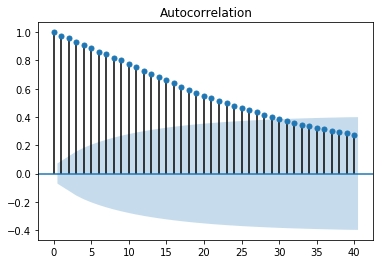

In [5]:
plot_acf(signals_df["Close"], lags = 40)
plt.show()

Nel nostro caso si vede sia una dipendenza dal trend, le barre hanno un andamento lento e decrescente all'aumentare di k, una dipendenza stagionale.  
Con le autocorrelazioni globali vediamo l'effetto su Xt dovuto a Xt−h, ma come capire se c'è un effetto dovuto agli istanti intermedi? Ci vengono in supporto le autocorrelazioni parziali ([pacf](https://www.statsmodels.org/devel/generated/statsmodels.tsa.stattools.pacf.html)) che misurano la dipendenza tra i due istanti al netto dell'influenza di quelli intermedi.

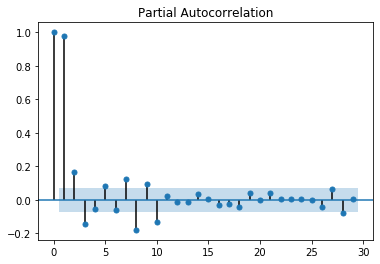

In [6]:
prt_acf = pacf(signals_df["Close"])

plot_pacf(signals_df["Close"])
plt.show()

Anche in questo caso si vede la non stazionarietà, valori fuori dalle bande.

## TEST STATISTICI

Fino ad ora abbiamo accertato che la serie NON è stazionaria, di seguito verranno illustrati due test che consentono di vedere se la stazionarietà persiste anche dopo aver applicato la procedura di "differenziazione", ovvero dopo aver eliminato gli effetti dovuti al trend. [Questi test si chiamano d'ipotesi perchè vanno a verificare la bontà di una ipotesi](https://it.wikipedia.org/wiki/Test_di_verifica_d%27ipotesi). Per ipotesi è da intendersi un'affermazione che ha come oggetto accadimenti nel mondo reale, che si presta ad essere confermata o smentita dai dati osservati sperimentalmente. L'ipotesi da verificare è detta nulla e si indica con H0, H1 invece è l'ipotesi alternativa.  

Prima di introdurre i due test creiamo una funzione per valutare se accettare o rigettare l'ipotesi nulla. Per farlo và confrontato il [p-value](https://it.wikipedia.org/wiki/Valore_p) con [il livello di significatività](https://it.wikipedia.org/wiki/Significativit%C3%A0) del test indicato con α, solitamente il valore di quest'ultimo è pari a 0.05 in quanto si ritiene che sufficientemente piccolo da poter concludere che sia "piuttosto improbabile" che la differenza osservata sia dovuta al semplice caso. Altri valori utilizzati sono 0.1 in fase esplorativa di alcuni test e uno più stringente 0.01.

In [7]:
def hypothesis(p_value, alpha):
    if p_value<= alpha:
        print("Non accettiamo H0")
    else:
        print("Accettiamo H0")

### Test di Dickey-Fuller

In [8]:
adf = adfuller(signals_df["Close"], regression="ct")

In [9]:
hypothesis(p_value=round(adf[1],2), alpha=0.05)

Non accettiamo H0


### Test di Kwiatkowski, Phillips, Schmidt e Shin (KPSS)

In [10]:
kpss_test = kpss(signals_df["Close"], regression = 'ct', lags=13)

In [11]:
hypothesis(round(kpss_test[1],2), alpha=0.05)

Accettiamo H0


## Rendere la serie stazionaria

Per rendere la serie stazionaria bisogna differenziare, la [differenziazione](https://it.wikipedia.org/wiki/Processo_stazionario#Differenziazione) non è altro che calcolare le differenze tra osservazioni consecutive. Il trend è lineare quindi dovrei rendere la serie stazionaria con una sola differenziazione.

Text(0.5, 1.0, 'Close [stazionaria?]')

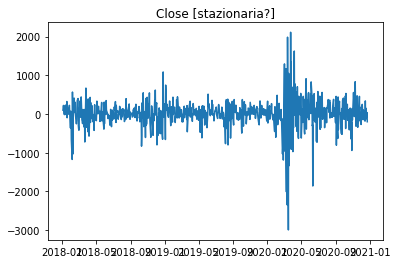

In [12]:
stat = signals_df["Close"].diff(periods=1)

plt.plot(stat)
plt.title("Close [stazionaria?]")

Rieffettuiamo i test precedenti con il parametro regression=c.

In [31]:
adf_stat = adfuller(stat.values[1:])
print("p-value: ", round(adf_stat[1], 2))
hypothesis(p_value=round(adf_stat[1], 2), alpha=0.05)

p-value:  0.0
Non accettiamo H0


In [33]:
kpss_stat = kpss(stat.values[1:], lags = 13)
print("p-value: ", round(kpss_stat[1], 2))
hypothesis(p_value=round(kpss_stat[1], 2), alpha=0.05)

p-value:  0.1
Accettiamo H0


Come accennato inizialmente la stazionarietà è una delle proprietà che la serie deve avere per essere analizzata con i modelli autoregressivi, per esempio, nel modello ARIMA(p,d,q), il parametro p è dato proprio studiando i grafici delle ACF e PACF, mentre il parametro d è l'ordine delle differenze che viene adottato, nel nostro caso 1 perchè abbiamo differenziato solo una volta, per completezza diciamo anche che il parametro q rappresenta la parte di media mobile, utilizza la dipendenza tra un’osservazione e un errore residuo da un modello a media mobile applicato alle osservazioni ritardate.

In [13]:
stat

Date
2018-01-02            NaN
2018-01-03      98.669922
2018-01-04     152.451172
2018-01-05     220.738281
2018-01-08     -12.869141
2018-01-09     102.800781
2018-01-10     -16.669922
2018-01-11     205.599609
2018-01-12     228.458984
2018-01-16     -10.330078
2018-01-17     322.791016
2018-01-18     -97.839844
2018-01-19      53.910156
2018-01-22     142.878906
2018-01-23      -3.789062
2018-01-24      41.308594
2018-01-25     140.669922
2018-01-26     223.921875
2018-01-29    -177.230469
2018-01-30    -362.589844
2018-01-31      72.500000
2018-02-01      37.320312
2018-02-02    -665.750000
2018-02-05   -1175.210938
2018-02-06     567.019531
2018-02-07     -19.419922
2018-02-08   -1032.888672
2018-02-09     330.439453
2018-02-12     410.369141
2018-02-13      39.179688
                 ...     
2020-11-10     262.949219
2020-11-11     -23.289062
2020-11-12    -317.460938
2020-11-13     399.640625
2020-11-16     470.628906
2020-11-17    -167.089844
2020-11-18    -344.929688
2020-11